# 浙江电力负荷预测-Temporal Fusion Transformer
In this notebook, we show two examples of how two use Darts' `TFTModel`.
If you are new to darts, we recommend you first follow the [quick start](https://unit8co.github.io/darts/quickstart/00-quickstart.html) notebook.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Temporal Fusion Transformer (TFT)

Darts' `TFTModel` incorporates the following main components from the original Temporal Fusion Transformer (TFT) architecture as outlined in [this paper](https://arxiv.org/pdf/1912.09363.pdf):

- gating mechanisms: skip over unused components of the model architecture
- variable selection networks: select relevant input variables at each time step.
- temporal processing of past and future input with LSTMs (long short-term memory)
- multi-head attention: captures long-term temporal dependencies
- prediction intervals: per default, produces quantile forecasts instead of deterministic values

### Training
`TFTModel` can be trained with past and future covariates. It is trained sequentially on fixed-size chunks consisting of an encoder and a decoder part:

- encoder: past input with `input_chunk_length`
  - **past target**: mandatory
  - **past covariates**: optional
- decoder: future known input with `output_chunk_length`
  - **future covariates**: mandatory (if none are available, consider `TFTModel`'s optional arguments `add_encoders` or `add_relative_index` from [here](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html?highlight=tftmodel#temporal-fusion-transformer-tft))

In each iteration, the model produces a quantile prediction of shape `(output_chunk_length, n_quantiles)` on the decoder part.

### Forecast
#### Probabilistic Forecast
Per default, `TFTModel` produces probabilistic quantile forecasts using `QuantileRegression`.
This gives the range of likely target values at each prediction step.
Most deep learning models in Darts'  - including `TFTModel` -  support `QuantileRegression` and 16 other likelihoods to produce probabilistic forecasts by setting `likelihood=MyLikelihood()` at model creation.

To produce meaningful results, set `num_samples >> 1` when predicting. For example:

```
model.predict(*args, **kwargs, num_samples=200)
```

Predictions with forecasting horizon `n` are generated auto-regressively using encoder-decoder chunks of the same size as during training.

If `n > output_chunk_length`, you have to supply additional future values for the covariates you passed to `model.train()`.

#### Deterministic Forecast
To produce deterministic rather than probabilistic forecasts, set parameter `likelihood` to `None` and `loss_fn` to a PyTorch loss function at model creation. For example:

```
model = TFTModel(*args, **kwargs, likelihood=None, loss_fn=torch.nn.MSELoss())
...
model.predict(*args, **kwargs, num_samples=1)
```

In [4]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

## Example
This data set that is highly dependent on covariates. Knowing the month tells us a lot about the seasonal component, whereas the year determines the effect of the trend component.

Additionally, let's convert the time index to integer values and use them as covariates as well. 

All of the three covariates are known in the future, and can be used as `future_covariates` with the `TFTModel`.

In [5]:
# Read data
#series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
#series = series / TimeSeries.from_series(series.time_index.days_in_month)
#series = series.astype(np.float32)

ts = pd.read_csv('/home/tutu/darts/datasets/data.csv')
#print(ts)
series = TimeSeries.from_dataframe(ts, time_col='year')

start_year = pd.Timestamp("2021-01")
train, val = series.split_after(start_year)


ld = series.pd_dataframe().values.tolist()
ld = [f'{item[0]:.2f}' for item in ld]
#####print(f'[ld]({len(ld)}): {ld}')

# Create training and validation sets:
# training_cutoff = pd.Timestamp("19571201")
training_cutoff = start_year
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
# -----------------------------------------1--------------------------------------------
#covariates1 = datetime_attribute_timeseries(series, attribute="year", one_hot=False)

#####print(f'{"="*80}')
series1 = series
year_list = [
        "2024-01", "2025-01", "2026-01",
        "2027-01", "2028-01", "2029-01",
        "2030-01", "2031-01", "2032-01",
        "2033-01", "2034-01", "2035-01",
        "2036-01", "2037-01", "2038-01",
        "2039-01", "2040-01",
    ]
new_data = pd.DataFrame({
    "year":year_list,
    "power":[0.0]*len(year_list),
    "electricity":[0.0]*len(year_list),
})
series1 = series1.append(TimeSeries.from_dataframe(new_data, time_col='year'))
#####print(f'-------------series1: {series1}------------')








ldss = series.pd_dataframe().values.tolist()
ldss = [f'{item[0]:.2f}' for item in ldss]
#####print(f'[ldss]({len(ldss)}): {ldss}')

#print(f'{"="*80}')
#series1.append_values([3,3,3,3])

ldss1 = series1.pd_dataframe().values.tolist()
ldss1 = [f'{item[0]:.2f}' for item in ldss1]
#####print(f'[ldss1]({len(ldss1)}): {ldss1}')



covariates1 = datetime_attribute_timeseries(series1, attribute="day", one_hot=False)
#####print(f'{"="*80}')
ld1_covariates = covariates1.pd_dataframe().values.tolist()
#####print(f'ld1_covariates: {ld1_covariates}')

# -----------------------------------------2--------------------------------------------
covariates2 = covariates1.stack(
    #datetime_attribute_timeseries(series, attribute="month", one_hot=False)
    datetime_attribute_timeseries(series1, attribute="day", one_hot=False)
)
#####print(f'{"="*80}')
ld2_covariates = covariates2.pd_dataframe().values.tolist()
# print(f'ld2_covariates: {ld2_covariates}')

# -----------------------------------------3--------------------------------------------
covariates3 = covariates2.stack(
    TimeSeries.from_times_and_values(
        times=series1.time_index,
        values=np.arange(len(series1)),
        columns=["linear_increase"],
    )
)

covariates3 = covariates3.astype(np.float32)
#####print(f'{"="*80}')
ld3_covariates = covariates3.pd_dataframe().values.tolist()
#####print(f'ld3_covariates: {ld3_covariates}')

# -------------------------------------------------------------------------------------
co = covariates3
#co['month'] = 1.0
#print(co)

#test = co.pd_dataframe().values.tolist()
#for item in test:
#    item[1] = 1.0
    
#print(f'test: {test}')
#co = pd.DataFrame(test, columns=['year', 'month', 'day'])
#test1 = co.values.tolist()
#print(f'test1: {test1}')

#co = TimeSeries.from_dataframe(co, time_col='day')





# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = co.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(co)
#####print(f'{"="*80}')
ld1_covariates_transformed = covariates_transformed.pd_dataframe().values.tolist()
#####print(f'ld1_covariates_transformed({len(ld1_covariates_transformed)}): {ld1_covariates_transformed}')

### Create a model
If you want to produce deterministic forecasts rather than quantile forecasts, you can use a PyTorch loss function (i.e., set `loss_fn=torch.nn.MSELoss()` and `likelihood=None`).

The `TFTModel` can only be used if some future input is given. Optional parameters `add_encoders` and `add_relative_index` can be useful, especially if we don't have
any future input available.<br>
They generate encoded temporal data that is used as future covariates.

Since we already have future covariates defined in our example they are commented out.

In [6]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
#input_chunk_length = 24
#forecast_horizon = 12
input_chunk_length = 12
forecast_horizon = 6
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

### Train the TFT

In what follows, we can just provide the whole `covariates` series as `future_covariates` argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target `train_transformed`:

In [7]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)
#my_cov = TimeSeries.from_dataframe(pd.DataFrame(range(0,144)))
# = TimeSeries.from_dataframe(ts, time_col='year')

#my_model.fit(train_transformed, future_covariates=my_cov, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=12, output_chunk_length=6, batch_size=16, n_epochs=300, add_encoders=None, random_state=42)

### Look at predictions on the validation set
We perform a one-shot prediction of 24 months using the "current" model - i.e., the model at the end of the training procedure:

Predicting: |          | 0/? [00:00<?, ?it/s]

max1: 10707.046746587306
max2: 6149.38812652701
max1: 11512.197237368637
max2: 6498.200586871489
max1: 12257.945524572464
max2: 6837.472103000336
max1: 12872.122509608316
max2: 7121.927154048288
max1: 13356.303628263182
max2: 7350.017274322092
max1: 13690.958753194816
max2: 7531.706797565179
max1: 13283.033695783255
max2: 7473.337327516856
max1: 13865.999892688971
max2: 7678.771006954473
max1: 14268.071743647313
max2: 7840.490158676605
max1: 14575.062472966152
max2: 7965.088742855792
max1: 14798.130961748971
max2: 8064.054761248596
max1: 14941.374552421155
max2: 8145.066380098854
max1: 14685.276872082275
max2: 8143.9118534421705
max1: 14798.197099126426
max2: 7914.263765206836
max1: 15067.924196122794
max2: 8269.519099879592
max1: 15196.510702190912
max2: 8325.209801207657
max1: 15401.444215021602
max2: 8379.398741443394
max1: 15509.17025012491
max2: 8428.570063276167
max1: 15646.41843679187
max2: 8473.103246707633
output:
10707.046746587306
11512.197237368637
12257.945524572464
12872.

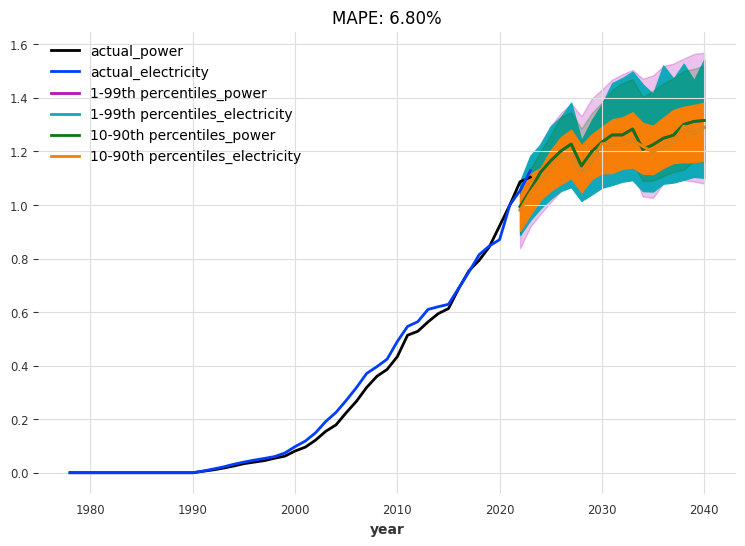

In [60]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)
    #print(f'pred_series: {pred_series}')
    ld = pred_series.pd_dataframe()
    #print(f'prediction result: {ld}')

    ld = pred_series.pd_dataframe()
    for ii in ld:
        pass
        #print(f'ld_ii: {ii}')

    i=0
    output_list = []
    for item in transformer.inverse_transform(pred_series):
        i += 1
        j=0
        line = item.pd_dataframe().values[0]
        #print(f'len of line[{i}]: {len(line)}')
        ###print(f'line[{i}]: {line}')

        #if i==1:
            #print(f'line1: {line} len: {len(line)}')
            #print(f'linea: {line[:200]}')
            #print(f'lineb: {line[200:]}')
        max1 = max(line[:200])
        print(f'max1: {max1}')
        max2 = max(line[200:])
        print(f'max2: {max2}')
        #print(f'item: {item}')
        ld0 = item.pd_dataframe().values.tolist()
        #aver = sum(ld0[0])/len(ld0[0])
        ma = max(ld0[0])
        output_list.append([max1, max2])

    print(f'output:')
    for out in output_list:
        print(f'{out[0]}')
    for out in output_list:
        print(f'{out[1]}')

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


#eval_model(my_model, 24, series_transformed, val_transformed)
eval_model(my_model, 19, series_transformed, val_transformed)

### Backtesting
Let's backtest our `TFTModel` model, to see how it performs with a forecast horizon of 12 months over the last 3 years:

In [10]:
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

ValueError: `start` time `2022-01-01 00:00:00` is too late in the series 0 to make any predictions with `overlap_end` set to `False`.

In [ ]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )


eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon,
    start=training_cutoff,
    transformer=transformer,
)

## Monthly ice cream sales
Let's try a another data set. That of monthly ice cream and heater sales since 2004. Our target is to predict future ice cream sales.
First, we build the time series from the data, and check its periodicity.

In [ ]:
series_ice_heater = IceCreamHeaterDataset().load()

plt.figure(figsize=figsize)
series_ice_heater.plot()

print(check_seasonality(series_ice_heater["ice cream"], max_lag=36))
print(check_seasonality(series_ice_heater["heater"], max_lag=36))

plt.figure(figsize=figsize)
plot_acf(series_ice_heater["ice cream"], 12, max_lag=36)  # ~1 year seasonality

### Process the data
We again have a 12-month seasonality. This time we will not define monthly future covariates -> we let the model handle this itself!

Let's define past covariates instead. What if we used past data of heater sales to predict ice cream sales?

In [ ]:
# convert monthly sales to average daily sales per month
converted_series = []
for col in ["ice cream", "heater"]:
    converted_series.append(
        series_ice_heater[col]
        / TimeSeries.from_series(series_ice_heater.time_index.days_in_month)
    )
converted_series = concatenate(converted_series, axis=1)
converted_series = converted_series[pd.Timestamp("20100101") :]

# define train/validation cutoff time
forecast_horizon_ice = 12
training_cutoff_ice = converted_series.time_index[-(2 * forecast_horizon_ice)]

# use ice cream sales as target, create train and validation sets and transform data
series_ice = converted_series["ice cream"]
train_ice, val_ice = series_ice.split_before(training_cutoff_ice)
transformer_ice = Scaler()
train_ice_transformed = transformer_ice.fit_transform(train_ice)
val_ice_transformed = transformer_ice.transform(val_ice)
series_ice_transformed = transformer_ice.transform(series_ice)

# use heater sales as past covariates and transform data
covariates_heat = converted_series["heater"]
cov_heat_train, cov_heat_val = covariates_heat.split_before(training_cutoff_ice)
transformer_heat = Scaler()
transformer_heat.fit(cov_heat_train)
covariates_heat_transformed = transformer_heat.transform(covariates_heat)

### Create a model with automatically generated future covariates and train it

Since we don't have future covariates defined, we need tell the model to generate future covariates itself.

- `add_encoders`: can add multiple encodings as past and / or future covariates from datetime attributes, cyclic repeating temporal patterns, index positions and customm functions for index encodings. You can even add a transformer that handles proper scaling of the training, validation and prediction data! Read more about it in the `TFTModel` docs [from here](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html#temporal-fusion-transformer-tft)
- `add_relative_index`: adds a scaled integer position relative to the prediction point for each encoder-decoder chunk (this might be useful if you really don't want to use any future covariates. The position values remain constant over all chunks and do not add additional information).

We use `add_encoders={'cyclic': {'future': ['month']}}` to account for the 12-month seasonality as a future covariate..

In [ ]:
# use the last 3 years as past input data
input_chunk_length_ice = 36

# use `add_encoders` as we don't have future covariates
my_model_ice = TFTModel(
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    hidden_size=32,
    lstm_layers=1,
    batch_size=16,
    n_epochs=300,
    dropout=0.1,
    add_encoders={"cyclic": {"future": ["month"]}},
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)

# fit the model with past covariates
my_model_ice.fit(
    train_ice_transformed, past_covariates=covariates_heat_transformed, verbose=True
)

### Look at predictions on the validation set
Again, we perform a one-shot prediction of 24 months using the "current" model - i.e., the model at the end of the training procedure:

In [ ]:
n = 24
eval_model(
    model=my_model_ice,
    n=n,
    actual_series=series_ice_transformed[
        train_ice.end_time() - (2 * n - 1) * train_ice.freq :
    ],
    val_series=val_ice_transformed,
)

### Backtesting
Let's backtest our `TFTModel` model, to see how it performs with a forecast horizon of 12 months over the last 2 years:

In [ ]:
# Compute the backtest predictions with the two models
last_points_only = False
backtest_series_ice = my_model_ice.historical_forecasts(
    series_ice_transformed,
    num_samples=num_samples,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=1 if last_points_only else forecast_horizon_ice,
    retrain=False,
    last_points_only=last_points_only,
    overlap_end=True,
    verbose=True,
)

backtest_series_ice = (
    concatenate(backtest_series_ice)
    if isinstance(backtest_series_ice, list)
    else backtest_series_ice
)

In [ ]:
eval_backtest(
    backtest_series=backtest_series_ice,
    actual_series=series_ice_transformed[
        train_ice.start_time() - 2 * forecast_horizon_ice * train_ice.freq :
    ],
    horizon=forecast_horizon_ice,
    start=training_cutoff_ice,
    transformer=transformer_ice,
)

### Explainability
Let's try to understand what our `TFTModel` model has learned. It would be nice to see the feature importance and how much the model attentds to past and future input.

The `TFTExplainer` does exactly that! You can find the documentation [here](https://unit8co.github.io/darts/generated_api/darts.explainability.tft_explainer.html).

In [ ]:
from darts.explainability import TFTExplainer

To instantiate the explainer we have two options:
- pass a custom background series input to be used as the default input for explanation.
- let the explainer load the background from the model automatically. This is only possible if the model was trained on a single target series (as in our case).

In [ ]:
explainer = TFTExplainer(my_model_ice)

Now we can generate the explanations with `explain()`. For this we again have two options:
- pass a custom foreground series input to be explained
- don't pass any foreground to explain the background

In [ ]:
explainability_result = explainer.explain()

Let's look at the feature importances:
- encoder feature importance: contains past target, past covariates and "historic" future covariates (the values of future covariates in the input chunk)
- decoder fetaure importance: contains "future" future covariates (the values of future covariates in the output chunk)
- static covariates importance: the importances of the static variables (only displayed if the model was trained on `series` with static covariates)

In [ ]:
explainer.plot_variable_selection(explainability_result)

As expected, the past history of ice cream sales is the most important feature in the encoder.
The cyclic encoding of the month also helped in the encoder and decoder to learn seasonal patterns.

Let's look at the attention (weights) that the model put on past and future input.

We have multiple plotting options:

`plot_type`
- "time" - plots the attention aggregated over all predictions steps
- "all" - plots the attention for each prediction step individually (ranges from `1` until `output_chunk_length`)
- "heatmap" - plots all the attention for each prediction step as a heatmap

`show_index_as`
- "relative" - sets the x-axis relative to the first predicted time step, ranging from `-input_chunk_length` until `output_chunk_length - 1`. `0` indicates the first predicted time step (highlighted by a dashed line).
- "time" - Uses the actual time index on the x-axis. The dashed line highlights the first predicted time step.

In [ ]:
explainer.plot_attention(explainability_result, plot_type="time")

We can see interesting attention areas:
- maximum attention at relative index -12. This indicates a yearly seasonality which makes sense for ice cream sales.
- high attention at the start (-36) of the input chunk: this is probably both from catching the value range of current input and the seasonality (-3 years)
- higher attention towards the end (-1) of the input chunk: the model puts attention on the recent past
- attention on future input (we look at this more in the next plot)

In [ ]:
explainer.plot_attention(explainability_result, plot_type="all")

On the output chunk (index 0 - 11), we see that the model only attends to the past relative of each horizon. This is because `TFTModel` uses `full_attention=False` by default. When setting this to `True`, the model will also attend to current, and future input.

In [ ]:
explainer.plot_attention(explainability_result, plot_type="heatmap")

We can also get the values directly from the `exlainability_result`. You can find the documentation [here](https://unit8co.github.io/darts/generated_api/darts.explainability.explainability_result.html#darts.explainability.explainability_result.TFTExplainabilityResult).

In [ ]:
explainability_result.get_encoder_importance()

In [ ]:
explainability_result.get_decoder_importance()

In [ ]:
explainability_result.get_static_covariates_importance()

We can also extract the attention as a TimeSeries, and plot it against the data.

In [ ]:
attention = explainability_result.get_attention().mean(axis=1)

time_intersection = train_ice_transformed.time_index.intersection(attention.time_index)

train_ice_transformed[time_intersection].plot()
attention.plot(label="mean_attention", max_nr_components=12)

### Some more information

Although we have only looked at a single univariate forecasting example, the `TFTExplainer` can be seemlessly applied to multivariate and / or multiple `TimeSeries` use cases.